---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-text-mining/resources/d9pwm) course resource._

---

*Note: Some of the cells in this notebook are computationally expensive. To reduce runtime, this notebook is using a subset of the data.*

# Case Study: Sentiment Analysis

### Data Prep

In [13]:
bb_chars={} 
Walter=''
Skyler=''
Jesse=''
Hank=''
Marie=''
Heisenberg=''
with open("breaking_bad_transcripts/season_all/merged.csv", "r+") as fp:
    for cnt, line in enumerate(fp):
        if line.startswith('Walter:'):
            Walter=Walter+' '+(line[8:])
        elif line.startswith('Skyler:'):
            Skyler=Skyler+' '+(line[8:])
        elif line.startswith('Jesse:'):
            Jesse=Jesse+' '+(line[7:])
        elif line.startswith('Hank:'):
            Hank=Hank+' '+(line[6:])
        if line.startswith('Marie:'):
            Marie=Marie+' '+(line[7:])
        if line.startswith('Heisenberg:'):
            Heisenberg=Heisenberg+' '+(line[12:])

bb_chars['Walter']=Walter
bb_chars['Skyler']=Skyler
bb_chars['Jesse']=Jesse
bb_chars['Hank']=Hank
bb_chars['Marie']=Marie


In [14]:

import pandas as pd
df1 = pd.DataFrame([x for x in bb_chars['Walter'].split('\n')])

df2 = pd.DataFrame([x for x in bb_chars['Skyler'].split('\n')])

df3 = pd.DataFrame([x for x in bb_chars['Jesse'].split('\n')])
df4 = pd.DataFrame([x for x in bb_chars['Hank'].split('\n')])

df5 = pd.DataFrame([x for x in bb_chars['Marie'].split('\n')])


In [15]:
pd.options.display.max_colwidth = 100

In [16]:
df1.head()

,0
0,How does it feel to be a smart ass?
1,"I was curious. Honestly, I never expected you to amount to much, but methamphetamine? I didn't ..."
2,"""Cap'n Cook?"" That's not you? Like I said, no one is looking for you."
3,Not really.
4,Short speech. You lost your partner today. What's his name – Emilio? Emilio is going to prison....


In [17]:
listOfCharacters1 = [True] *df1.shape[0]
listOfCharacters2 = [False] *df2.shape[0]
listOfCharacters3 = [False] *df3.shape[0]
listOfCharacters4 = [False] *df4.shape[0]
listOfCharacters5 = [False] *df5.shape[0]


In [18]:
df1['Walter'] = listOfCharacters1
df2['Walter'] = listOfCharacters2 
df3['Walter'] = listOfCharacters3
df4['Walter'] = listOfCharacters4
df5['Walter'] = listOfCharacters5


In [19]:
df1=df1.rename(columns={0: 'Dialogue'})
df2=df2.rename(columns={0: 'Dialogue'})
df3=df3.rename(columns={0: 'Dialogue'})
df4=df4.rename(columns={0: 'Dialogue'})
df5=df5.rename(columns={0: 'Dialogue'})


In [20]:
df = pd.concat([df1, df2,df3,df4,df5])
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,Dialogue,Walter
0,"That's not why I'm here, Jesse. There's more. It's more than an assistant. Partners. We'd be pa...",True
1,"How about something with some protein, maybe? Something green, huh? How are you even alive?",True
2,What the f...?,True
3,"He poisoned a little kid. An eight-year-old boy. Just because, you know– just as a move!",False
4,"Well, we're set. Boys are ready. Gonna make some mad cheddar, yo. [Walter looks at Jesse] Chedd...",False


In [21]:
df.head(10)

,Dialogue,Walter
0,"That's not why I'm here, Jesse. There's more. It's more than an assistant. Partners. We'd be pa...",True
1,"How about something with some protein, maybe? Something green, huh? How are you even alive?",True
2,What the f...?,True
3,"He poisoned a little kid. An eight-year-old boy. Just because, you know– just as a move!",False
4,"Well, we're set. Boys are ready. Gonna make some mad cheddar, yo. [Walter looks at Jesse] Chedd...",False
5,"So things are quiet, y'know? Not a lot of crystal on the streets right now.",False
6,I don't care.,False
7,"Uh, okay then. We just, uh, have a few questions. You're currently employed by the Pollos Herma...",False
8,Then get the fuck outta here and never come back.,False
9,I love you too.,False


In [22]:
from io import StringIO
col = [ 'Dialogue','Walter']
df = df[col]
df = df[pd.notnull(df['Dialogue'])]
df.columns = ['Dialogue', 'Walter']
category_id_df = df[['Dialogue', 'Walter']]
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['Walter', 'Dialogue']].values)
df.head(10)


,Dialogue,Walter
0,"That's not why I'm here, Jesse. There's more. It's more than an assistant. Partners. We'd be pa...",True
1,"How about something with some protein, maybe? Something green, huh? How are you even alive?",True
2,What the f...?,True
3,"He poisoned a little kid. An eight-year-old boy. Just because, you know– just as a move!",False
4,"Well, we're set. Boys are ready. Gonna make some mad cheddar, yo. [Walter looks at Jesse] Chedd...",False
5,"So things are quiet, y'know? Not a lot of crystal on the streets right now.",False
6,I don't care.,False
7,"Uh, okay then. We just, uh, have a few questions. You're currently employed by the Pollos Herma...",False
8,Then get the fuck outta here and never come back.,False
9,I love you too.,False


In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt


In [24]:
import re
from nltk.corpus import stopwords


df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Dialogue'] = df['Dialogue'].apply(clean_text)
df['Dialogue'] = df['Dialogue'].str.replace('\d+', '')
df.head()

,Dialogue,Walter
0,thats im jesse theres assistant partners wed partners split everything like million dollars,True
1,something protein maybe something green huh even alive,True
2,f,True
3,poisoned little kid eightyearold boy know move,False
4,well set boys ready gonna make mad cheddar yo walter looks jesse cheddar mr white fat stacks dea...,False


In [25]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [26]:

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 20000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 120
# This is fixed.
EMBEDDING_DIM = 64
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df1['Dialogue'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
word_index

Found 2416 unique tokens.


{'you': 1,
 'i': 2,
 'to': 3,
 'the': 4,
 'and': 5,
 'a': 6,
 'that': 7,
 'it': 8,
 'me': 9,
 'of': 10,
 'what': 11,
 'this': 12,
 'is': 13,
 'my': 14,
 'in': 15,
 'no': 16,
 'do': 17,
 'just': 18,
 'for': 19,
 'he': 20,
 'not': 21,
 'have': 22,
 'know': 23,
 'your': 24,
 "i'm": 25,
 'was': 26,
 'but': 27,
 'we': 28,
 'all': 29,
 'be': 30,
 "it's": 31,
 'so': 32,
 'on': 33,
 'are': 34,
 'with': 35,
 "don't": 36,
 'now': 37,
 'right': 38,
 'him': 39,
 'about': 40,
 'how': 41,
 'jesse': 42,
 'up': 43,
 'out': 44,
 'if': 45,
 '–': 46,
 'would': 47,
 'think': 48,
 'mean': 49,
 'as': 50,
 "you're": 51,
 'got': 52,
 'want': 53,
 'skyler': 54,
 'who': 55,
 "that's": 56,
 'get': 57,
 'one': 58,
 'like': 59,
 'can': 60,
 'money': 61,
 'his': 62,
 'at': 63,
 'did': 64,
 'will': 65,
 'there': 66,
 'here': 67,
 'am': 68,
 'need': 69,
 'going': 70,
 'gus': 71,
 'hank': 72,
 'why': 73,
 'when': 74,
 'they': 75,
 'could': 76,
 'or': 77,
 'go': 78,
 'good': 79,
 'then': 80,
 'some': 81,
 'nothing': 82

In [27]:
X = tokenizer.texts_to_sequences(df['Dialogue'].values)#df['Dialogue']#tokenizer.texts_to_sequences(df['Dialogue'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
X

Shape of data tensor: (1558, 120)


array([[   0,    0,    0, ...,   59,  175,  880],
       [   0,    0,    0, ...,  205,  100,  248],
       [   0,    0,    0, ...,    0,    0, 1238],
       ...,
       [   0,    0,    0, ...,   57,  316,  294],
       [   0,    0,    0, ...,    0,  213, 2267],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [28]:
Y = pd.get_dummies(df['Walter']).values#df['category_id']
#print('Shape of label tensor:', Y.shape)
Y

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [1, 0]], dtype=uint8)

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 0)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1043, 120) (1043, 2)
(515, 120) (515, 2)


In [30]:
X_test


array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ..., 1887,  177,  918],
       [   0,    0,    0, ...,   59,  500,  220],
       ...,
       [   0,    0,    0, ...,  809, 2023, 2024],
       [   0,    0,    0, ...,  208,  887, 2090],
       [   0,    0,    0, ...,  202,  540,   38]], dtype=int32)

In [31]:
Y_test


array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [1, 0],
       [0, 1]], dtype=uint8)

In [32]:
import tensorflow_datasets as tfds
import tensorflow as tf
print(tf.__version__)

2.0.0-beta0


In [33]:
X.shape[1]

120

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model1.add(tf.keras.layers.SpatialDropout1D(0.2))
model1.add(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model1.add(tf.keras.layers.Dense(2, activation='softmax'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model1.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

W1018 09:17:18.179074 140735584691072 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 938 samples, validate on 105 samples
Epoch 1/10
938/938 [==============================] - 2s 3ms/sample - loss: 0.6943 - accuracy: 0.5032 - val_loss: 0.6924 - val_accuracy: 0.5524
Epoch 2/10
938/938 [==============================] - 1s 1ms/sample - loss: 0.6873 - accuracy: 0.5821 - val_loss: 0.6907 - val_accuracy: 0.5524
Epoch 3/10
938/938 [==============================] - 1s 1ms/sample - loss: 0.6719 - accuracy: 0.6791 - val_loss: 0.6849 - val_accuracy: 0.5524
Epoch 4/10
938/938 [==============================] - 1s 1ms/sample - loss: 0.6255 - accuracy: 0.7399 - val_loss: 0.6756 - val_accuracy: 0.5714
Epoch 5/10
938/938 [==============================] - 1s 1ms/sample - loss: 0.5386 - accuracy: 0.7783 - val_loss: 0.6950 - val_accuracy: 0.5810
Epoch 6/10
938/938 [==============================] - 1s 1ms/sample - loss: 0.4641 - accuracy: 0.7868 - val_loss: 0.6822 - val_accuracy: 0.5619
Epoch 7/10
938/938 [==============================] - 1s 1ms/sample - loss: 0.3986 - accur

In [39]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 938 samples, validate on 105 samples
Epoch 1/10
938/938 [==============================] - 5s 6ms/sample - loss: 0.6942 - accuracy: 0.4984 - val_loss: 0.6929 - val_accuracy: 0.4857
Epoch 2/10
938/938 [==============================] - 3s 3ms/sample - loss: 0.6904 - accuracy: 0.5864 - val_loss: 0.6925 - val_accuracy: 0.4905
Epoch 3/10
938/938 [==============================] - 3s 3ms/sample - loss: 0.6713 - accuracy: 0.6338 - val_loss: 0.6836 - val_accuracy: 0.5571
Epoch 4/10
938/938 [==============================] - 3s 3ms/sample - loss: 0.5086 - accuracy: 0.7804 - val_loss: 0.8543 - val_accuracy: 0.5810
Epoch 5/10
938/938 [==============================] - 3s 3ms/sample - loss: 0.3786 - accuracy: 0.8289 - val_loss: 0.8361 - val_accuracy: 0.5524
Epoch 6/10
938/938 [==============================] - 2s 3ms/sample - loss: 0.2695 - accuracy: 0.8779 - val_loss: 1.0272 - val_accuracy: 0.5905


In [40]:
accr = model2.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

515/515 [==============================] - 2s 3ms/sample - loss: 1.0246 - accuracy: 0.6029
Test set
  Loss: 1.025
  Accuracy: 0.603


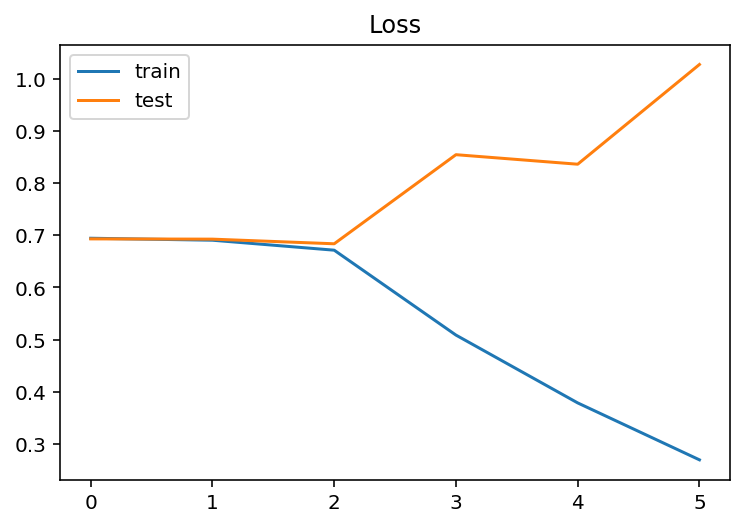

In [41]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [42]:
#model = LinearSVC()
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
#"model.fit(X_train, y_train)
# X_test = X_test.reshape(X_test.shape[1:])
# X_test=X_test.transpose()
y_pred = model1.predict(X_test)
y_pred



array([[0.5624201 , 0.43757987],
       [0.69176006, 0.30823994],
       [0.80765027, 0.19234967],
       ...,
       [0.11142606, 0.88857394],
       [0.13257608, 0.86742395],
       [0.24873468, 0.7512653 ]], dtype=float32)

In [43]:
Y_test


array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [1, 0],
       [0, 1]], dtype=uint8)

In [44]:
import numpy as np
probas = np.array(y_pred)
y_pred = np.argmax(probas, axis=-1)    
print(y_pred)

[0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 1 1
 1 1 0 0 0 1 0 1 1 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 1 1
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0 0
 1 0 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 0 1 0
 1 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 0
 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1
 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 1 1
 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1
 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 1 0
 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 0
 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 1
 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0
 0 1 0 0 1 0 0 0 1 1 1 0 

In [45]:
Y_test = np.array(Y_test)
Y_test = np.argmax(Y_test, axis=-1)    
print(Y_test)

[1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1
 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 1
 1 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1
 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 1 1 0
 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0 1 0
 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1
 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 0
 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1
 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 1 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1
 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1
 0 1 1 0 1 0 0 1 1 0 0 0 

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(Y_test, y_pred)



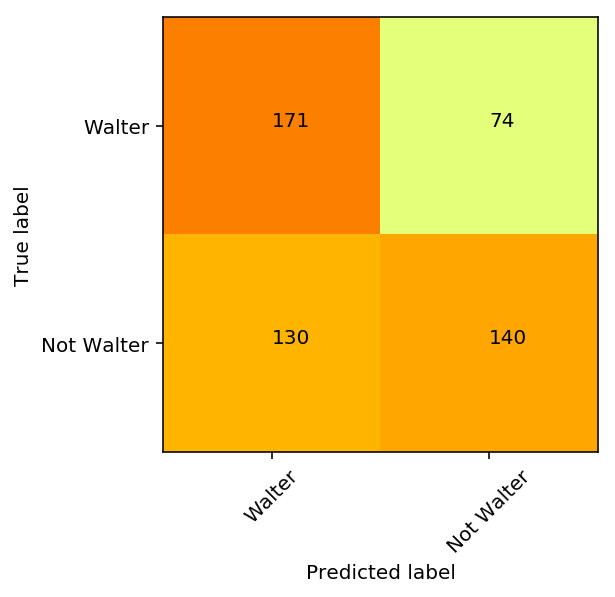

In [47]:
plt.clf()
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Walter','Not Walter']
#plt.title('Versicolor or Not Versicolor Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(conf_mat[i][j]))
plt.show()

In [48]:
from sklearn.metrics import classification_report
y_true = Y_test
target_names = ['Walter', 'Not Walter']
print(classification_report(y_true, y_pred, target_names=target_names))
     ####----end here---##

              precision    recall  f1-score   support

      Walter       0.57      0.70      0.63       245
  Not Walter       0.65      0.52      0.58       270

    accuracy                           0.60       515
   macro avg       0.61      0.61      0.60       515
weighted avg       0.61      0.60      0.60       515



In [190]:
Y_train = np.array(Y_train)
Y_train = np.argmax(Y_train, axis=-1)    
print(Y_train)

[0 0 0 ... 0 0 0]


In [191]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train, Y_train)
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
#print(clf.predict(X[2:3]))

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [192]:
y_pred1=clf.predict(X_test)

In [194]:
Y_test = np.array(Y_test)
Y_test = np.argmax(Y_test, axis=-1)    
print(Y_test)

[0 1 0 ... 0 0 0]


In [195]:
from sklearn.metrics import classification_report
y_true = Y_test
target_names = ['Chandler', 'Not Chandler']
print(classification_report(y_true, y_pred1, target_names=target_names))

              precision    recall  f1-score   support

    Chandler       0.84      1.00      0.91     27460
Not Chandler       0.25      0.00      0.00      5287

    accuracy                           0.84     32747
   macro avg       0.54      0.50      0.46     32747
weighted avg       0.74      0.84      0.77     32747

